# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

- Произвести предобработку данных. Изучить пропуски/дубликаты/аномалии
- Осуществить исследовательский анализ данных
- Подготовить признаки для последующего машинного обучения
- Обучить регрессионные модели
- Проверить модели на тестовой выборке, определить наиболее подходящую для конкретно задачи.

## Обзор данных

Импортируем необхоимые для выполнения проекта библиотеки и функции:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

Загрузим данные:

In [2]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Запишем функцию, которая последовательно даст общую информацию о каждом из датасетов:

In [3]:
def explanations(df):
    display(df.head())
    print('Всего пропусков:', df.isna().mean().mean())
    print('Всего дубликатов:', df.duplicated().sum())
    display(df.describe())
    df.info()

### Данные об электродах

In [4]:
explanations(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Всего пропусков: 0.0
Всего дубликатов: 0


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Значения реактивной мощности меньше нуля являются выбросами. Удалим их:

In [5]:
df_arc = df_arc[df_arc['Реактивная мощность'] >=0]

Вызовем describe еще раз, посмотрим количество уникальных 'key' в таблице, построим гистограммы для активной и реактивной мощностей:

In [6]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


<AxesSubplot:ylabel='Frequency'>

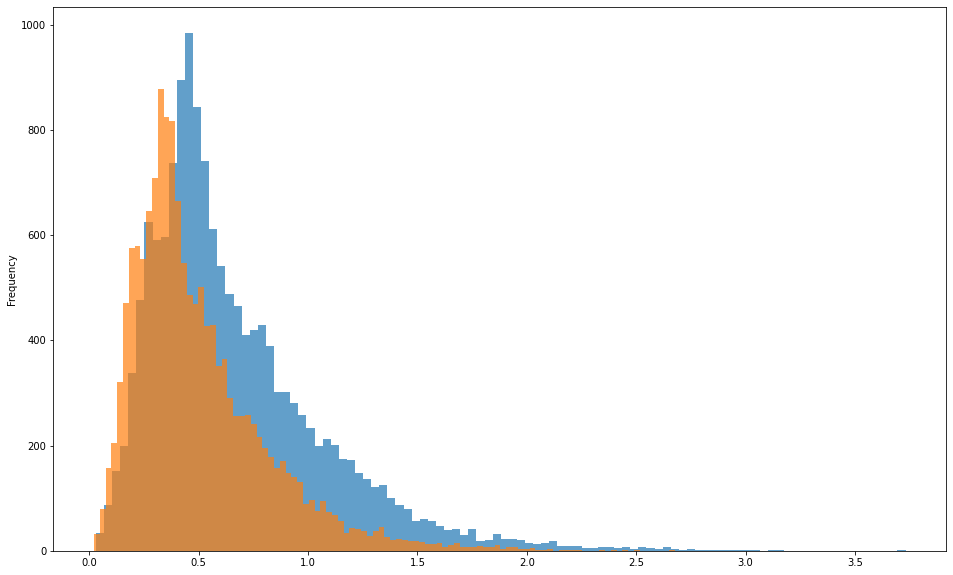

In [7]:
df_arc['Активная мощность'].plot(kind='hist', bins=100, figsize=(16,10), alpha=0.7, label='Активная')
df_arc['Реактивная мощность'].plot(kind='hist', bins=100, alpha=0.7, label='Реактивная')

In [8]:
len(df_arc['key'].unique())

3214

### Данные о подаче сыпучих материалов (объем)

In [9]:
explanations(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Всего пропусков: 0.7146053052093321
Всего дубликатов: 0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Посчитаем количество уникальных 'key' и заменим пропуски на нулевые значения:

In [10]:
df_bulk = df_bulk.fillna(0)
print(len(df_bulk['key'].unique()))

3129


### Данные о подаче сыпучих материалов (время)

In [11]:
explanations(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Всего пропусков: 0.7146053052093321
Всего дубликатов: 0


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В целом, данную таблицу можно рассматривать как дополнение к предыдущей. Насколько она окажется полезной, узнаем дальше.

### Данные о продувке сплава газом

In [12]:
explanations(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Всего пропусков: 0.0
Всего дубликатов: 0


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков и дубликатов нет. Посмотрим, как распределены значения в столбце "Газ 1" с помощью гистограммы. Посчитаем количество уникальных 'key':

<AxesSubplot:>

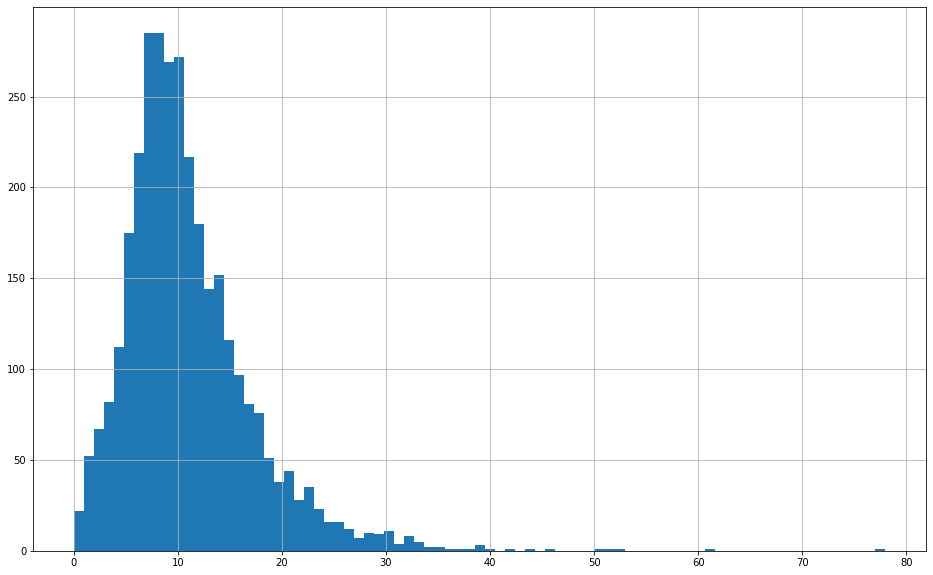

In [13]:
df_gas['Газ 1'].hist(bins=81, figsize=(16,10))

In [14]:
len(df_gas['key'].unique())

3239

### Данные о результатах измерения температуры

In [15]:
explanations(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Всего пропусков: 0.06079084679700761
Всего дубликатов: 0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Присутствуют пропуски в столбце 'Температура'. Построим гистограмму, посчитаем количество уникальных 'key'

<AxesSubplot:>

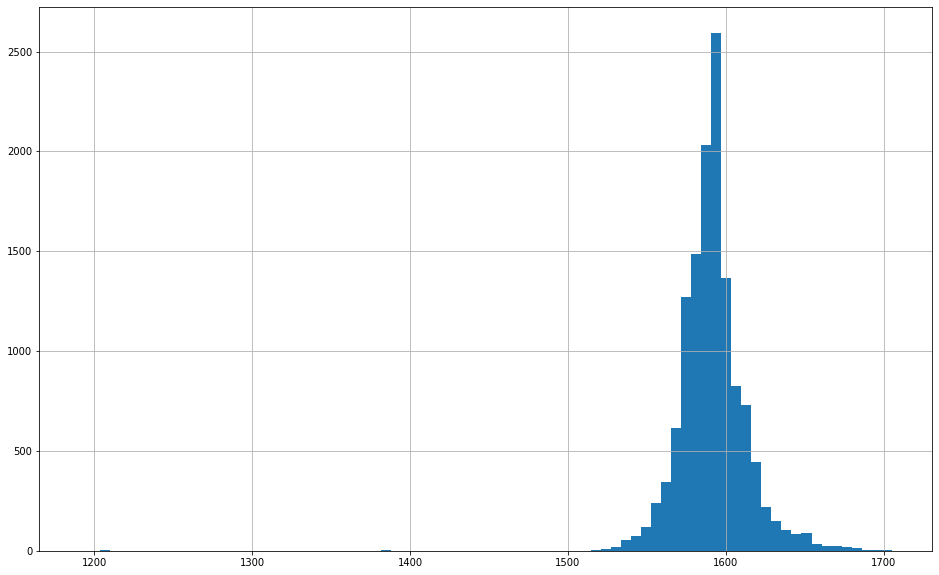

In [16]:
df_temp['Температура'].hist(bins=81, figsize=(16,10))

In [17]:
len(df_temp['key'].unique())

3216

### Данные о проволочных материалах (объем)

In [18]:
explanations(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего пропусков: 0.7590068159688413
Всего дубликатов: 0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Аналогично таблице с данными о сыпучих материалах, в таблице с проволочными материалами присутствует большое количество пропусков. Я думаю, это связано с тем что на определенных этапах не добавляются материалы, а если добавляются, то поштучно, а не все сразу. Выведем количество уникальных 'key'

In [19]:
len(df_wire['key'].unique())

3081

### Данные о проволочных материалах (время)

In [20]:
explanations(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего пропусков: 0.7590068159688413
Всего дубликатов: 0


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Как и в случае с сыпучими материалами, таблица со временем служит дополнением таблицы с объемами.

**ВЫВОД**

- В таблицах с данными о сыпучих и проволочных материалах много пропусков. Я думаю, это связано с особенностью технологического процесса. Поскольку в таблицах df_bulk и df_wire указаны 15 и 9 столбцов о различных материалах соответственно, это может означать, что в каждую партию может идти определенный набор из них и только единицам требуется использование всех возможных материалов.
- В таблицах разное количество уникальных 'key'. Это может быть связано, например, с утерей данных или с тем, что над определенными партями не производился технологический процесс.
- У многих столбцов несоответствующие типы данных (особенно часто object вместо datetime)
- Во избежание ошибок необходимо привести все названия столбцов к змеиному регистру

## Предобработка данных

Для удобства переименуем столбцы:

In [21]:
df_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']

Переведем тип данных к формату datetime и добавим столбец с суммарным количеством секунд, потраченных на нагрев:

In [22]:
df_arc['start_time'] = pd.to_datetime(df_arc['start_time'], format = '%Y-%m-%d %H:%M:%S')
df_arc['end_time'] = pd.to_datetime(df_arc['end_time'], format = '%Y-%m-%d %H:%M:%S')
df_arc['difference_seconds'] = (df_arc['end_time'] - df_arc['start_time']).dt.seconds

Сгруппируем данные по 'key'. Найдем суммарные активную и реактивную мощности:

In [23]:
df_arc_sum = df_arc.groupby('key').agg('sum')
df_arc_sum.head(10)

,active_power,reactive_power,difference_seconds
key,,,
1,4.878147,3.183241,1098
2,3.052598,1.998112,811
3,2.525882,1.599076,655
4,3.209250,2.060298,741
5,3.347173,2.252643,869
6,3.955108,2.689175,952
7,2.547375,1.561295,673
8,3.762755,2.680698,913
9,2.081951,1.478671,625


Посмотрим, коррелируют ли активная и реактивная мощности относительно друг друга:

In [24]:
df_arc_sum.corr()

,active_power,reactive_power,difference_seconds
active_power,1.000000,0.957892,0.978012
reactive_power,0.957892,1.000000,0.966837
difference_seconds,0.978012,0.966837,1.000000


Коэффициент Пирсона близок к единице, что говорит о высокой корреляции. Во избежание последующего переобучения модели, целесообразно перейти к суммарной мощности:

$$
S = \sqrt{(P^2 + Q^2)}
$$

In [25]:
df_arc_sum['full_power'] = (df_arc_sum['active_power'] ** 2 + df_arc_sum['reactive_power'] ** 2) ** (1 / 2)
df_arc_sum = df_arc_sum.drop(['active_power', 'reactive_power'], axis=1)
df_arc_sum

,difference_seconds,full_power
key,,
1,1098,5.824889
2,811,3.648398
3,655,2.989502
4,741,3.813674
5,869,4.034596
...,...,...
3237,909,4.844014
3238,546,2.695151
3239,1216,5.608989


Чем больше энергии было потрачено за нагрев, тем выше должна быть температура - логично. Посмотрим внимательнее на таблицу df_temp, а именно, изучем пропуски и количество замеров температуры:

In [26]:
display(df_temp)

number_of_measurements = pd.DataFrame(df_temp['key'].value_counts())
print('Количество замеров:')
number_of_measurements

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Количество замеров:


,key
46,16
1214,16
1513,16
44,16
1689,15
...,...
1415,2
1836,2
2456,2
195,1


В части данных есть пропуски, то есть не был выполнен финальный замер (целевой признак). Такие данные нам не нужны. Также избавимся от тех партий, где количество замеров меньше двух (есть только начальный замер):

In [27]:
bad_keys = df_temp.loc[df_temp['Температура'].isna()]['key'].unique() #строки с пропусками
also_bad_keys = np.array(number_of_measurements.loc[number_of_measurements['key']<2].index)

Оставим только те строки, которые нас устраивают:

In [28]:
df_temp = df_temp[~df_temp['key'].isin(bad_keys)].reset_index(drop = True)
df_temp = df_temp[~df_temp['key'].isin(also_bad_keys)].reset_index(drop = True)
display(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12260,2498,2019-08-06 02:19:26,1593.0
12261,2498,2019-08-06 02:25:31,1594.0
12262,2499,2019-08-06 02:40:25,1569.0
12263,2499,2019-08-06 02:54:24,1604.0


Необходимо получить таблицу с начальной температурой, конечной температурой и количеством измерений. Сделаем это:

In [29]:
number_of_measurements = pd.DataFrame(df_temp['key'].value_counts()).sort_index().reset_index() #столбец с количеством измерений

In [30]:
last_temp = pd.DataFrame()
first_temp = pd.DataFrame()
unique_key = df_temp['key'].unique()

for key in unique_key:
    last_temp = last_temp.append(df_temp.loc[df_temp['key'] == key].tail(1), ignore_index = True)
    first_temp = first_temp.append(df_temp.loc[df_temp['key'] == key].head(1), ignore_index = True)
    
df_temp_sum = first_temp.merge(last_temp,  how = 'inner', on = 'key')
df_temp_sum

,key,Время замера_x,Температура_x,Время замера_y,Температура_y
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...
2470,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2471,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2472,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2473,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0


In [31]:
df_temp_sum = df_temp_sum.drop(['Время замера_x', 'Время замера_y'], axis = 1)
df_temp_sum['measurements'] = number_of_measurements['key']
df_temp_sum.columns = ['key', 'first_temp', 'last_temp', 'measurements']
df_temp_sum

,key,first_temp,last_temp,measurements
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
...,...,...,...,...
2470,2495,1570.0,1591.0,3
2471,2496,1554.0,1591.0,4
2472,2497,1571.0,1589.0,2
2473,2498,1591.0,1594.0,5


**Объединим данные**

In [32]:
df_new = df_temp_sum.merge(df_arc_sum,  how ='left', on ='key')
df_new

,key,first_temp,last_temp,measurements,difference_seconds,full_power
0,1,1571.0,1613.0,5,1098,5.824889
1,2,1581.0,1602.0,6,811,3.648398
2,3,1596.0,1599.0,5,655,2.989502
3,4,1601.0,1625.0,3,741,3.813674
4,5,1576.0,1602.0,2,869,4.034596
...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3,723,3.985197
2471,2496,1554.0,1591.0,4,940,5.055976
2472,2497,1571.0,1589.0,2,569,2.884756
2473,2498,1591.0,1594.0,5,750,4.143362


Теперь к полученной таблице необходимо добавить данные из таблиц df_gas, df_bulk и df_wire. Если в df_bulk пропуски были заменены на нулевые значения еще на этапе обзора данных, но для df_wire это необходимо сделать сейчас:

In [33]:
df_wire = df_wire.fillna(0)
df_gas.columns = ['key', 'gas']

In [34]:
for df in [df_gas, df_bulk, df_wire]:
    df_new = df_new.merge(df, how='left', on='key')

In [35]:
df_new

,key,first_temp,last_temp,measurements,difference_seconds,full_power,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,5,1098,5.824889,29.749986,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,6,811,3.648398,12.555561,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,5,655,2.989502,28.554793,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,3,741,3.813674,18.841219,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,2,869,4.034596,5.413692,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3,723,3.985197,7.125735,0.0,0.0,21.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,2496,1554.0,1591.0,4,940,5.055976,9.412616,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,2497,1571.0,1589.0,2,569,2.884756,6.271699,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2498,1591.0,1594.0,5,750,4.143362,14.953657,0.0,0.0,90.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_new.isna().mean() #проверим, не появились ли пропуски при соединении таблиц

key                   0.000000
first_temp            0.000000
last_temp             0.000000
measurements          0.000000
difference_seconds    0.000000
full_power            0.000000
gas                   0.000808
Bulk 1                0.027475
Bulk 2                0.027475
Bulk 3                0.027475
Bulk 4                0.027475
Bulk 5                0.027475
Bulk 6                0.027475
Bulk 7                0.027475
Bulk 8                0.027475
Bulk 9                0.027475
Bulk 10               0.027475
Bulk 11               0.027475
Bulk 12               0.027475
Bulk 13               0.027475
Bulk 14               0.027475
Bulk 15               0.027475
Wire 1                0.041616
Wire 2                0.041616
Wire 3                0.041616
Wire 4                0.041616
Wire 5                0.041616
Wire 6                0.041616
Wire 7                0.041616
Wire 8                0.041616
Wire 9                0.041616
dtype: float64

Пропуски появились, но их количество составляет не более 5% в каждом из столбцов. Потому удалим их для успешного последующего обучения.

In [37]:
df_new = df_new.dropna()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2329 non-null   int64  
 1   first_temp          2329 non-null   float64
 2   last_temp           2329 non-null   float64
 3   measurements        2329 non-null   int64  
 4   difference_seconds  2329 non-null   int64  
 5   full_power          2329 non-null   float64
 6   gas                 2329 non-null   float64
 7   Bulk 1              2329 non-null   float64
 8   Bulk 2              2329 non-null   float64
 9   Bulk 3              2329 non-null   float64
 10  Bulk 4              2329 non-null   float64
 11  Bulk 5              2329 non-null   float64
 12  Bulk 6              2329 non-null   float64
 13  Bulk 7              2329 non-null   float64
 14  Bulk 8              2329 non-null   float64
 15  Bulk 9              2329 non-null   float64
 16  Bulk 1

Для экономии переведем тип данных в столбцах first_temp, last_temp и Bulk i к integer:

In [38]:
df_new['first_temp'] = df_new['first_temp'].astype('int')
df_new['last_temp'] = df_new['last_temp'].astype('int')
for i in range(1,16):
    df_new[f'Bulk {i}'] = df_new[f'Bulk {i}'].astype('int')

/tmp/ipykernel_290/1594629174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['first_temp'] = df_new['first_temp'].astype('int')
/tmp/ipykernel_290/1594629174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['last_temp'] = df_new['last_temp'].astype('int')
/tmp/ipykernel_290/1594629174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

На этапе предобработки были подготовлены данные для последующего анализа. Из начального набора датасетов выбраны необходимые данные, не иформативные для задачи столбцы не вошли в итоговую таблицу. Пропуски удалены.

## Исследовательский анализ данных

Посмотрим, коррелируют ли данные между собой:

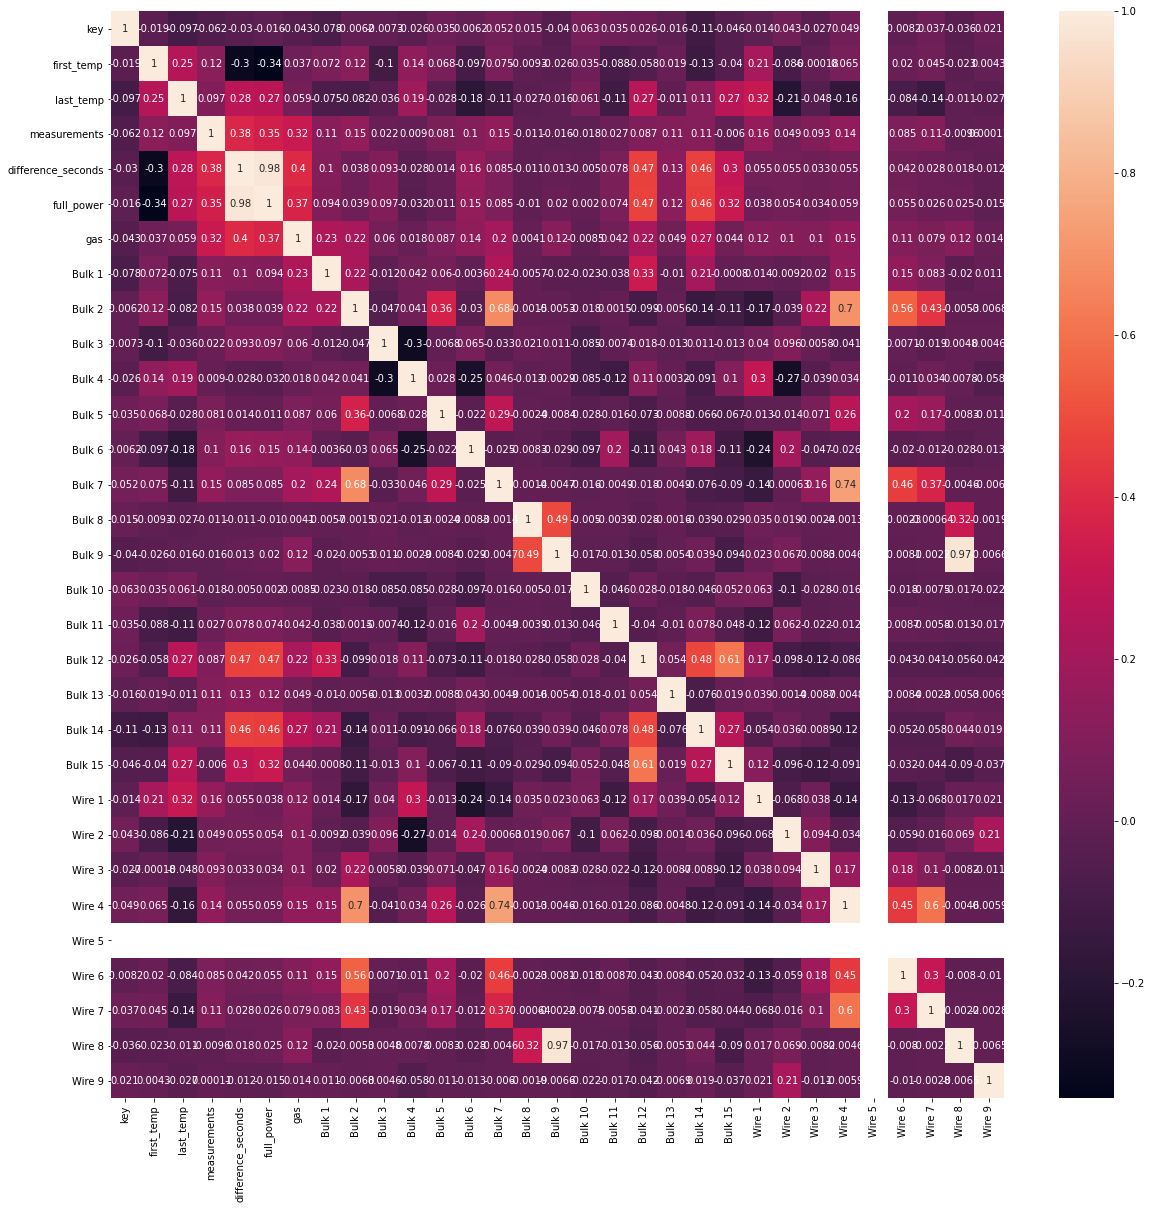

In [39]:
fig = plt.subplots(figsize=(20,20))
sns.heatmap(df_new.corr(), annot = True)
plt.show()

Изучим детально столбец Wire 5:

In [40]:
df_new['Wire 5'].unique()

array([0.])

Столбец неинформативен. Везде нулевые значения. Удалим его и построим тепловую карту заново:

In [41]:
df_new = df_new.drop('Wire 5', axis=1)

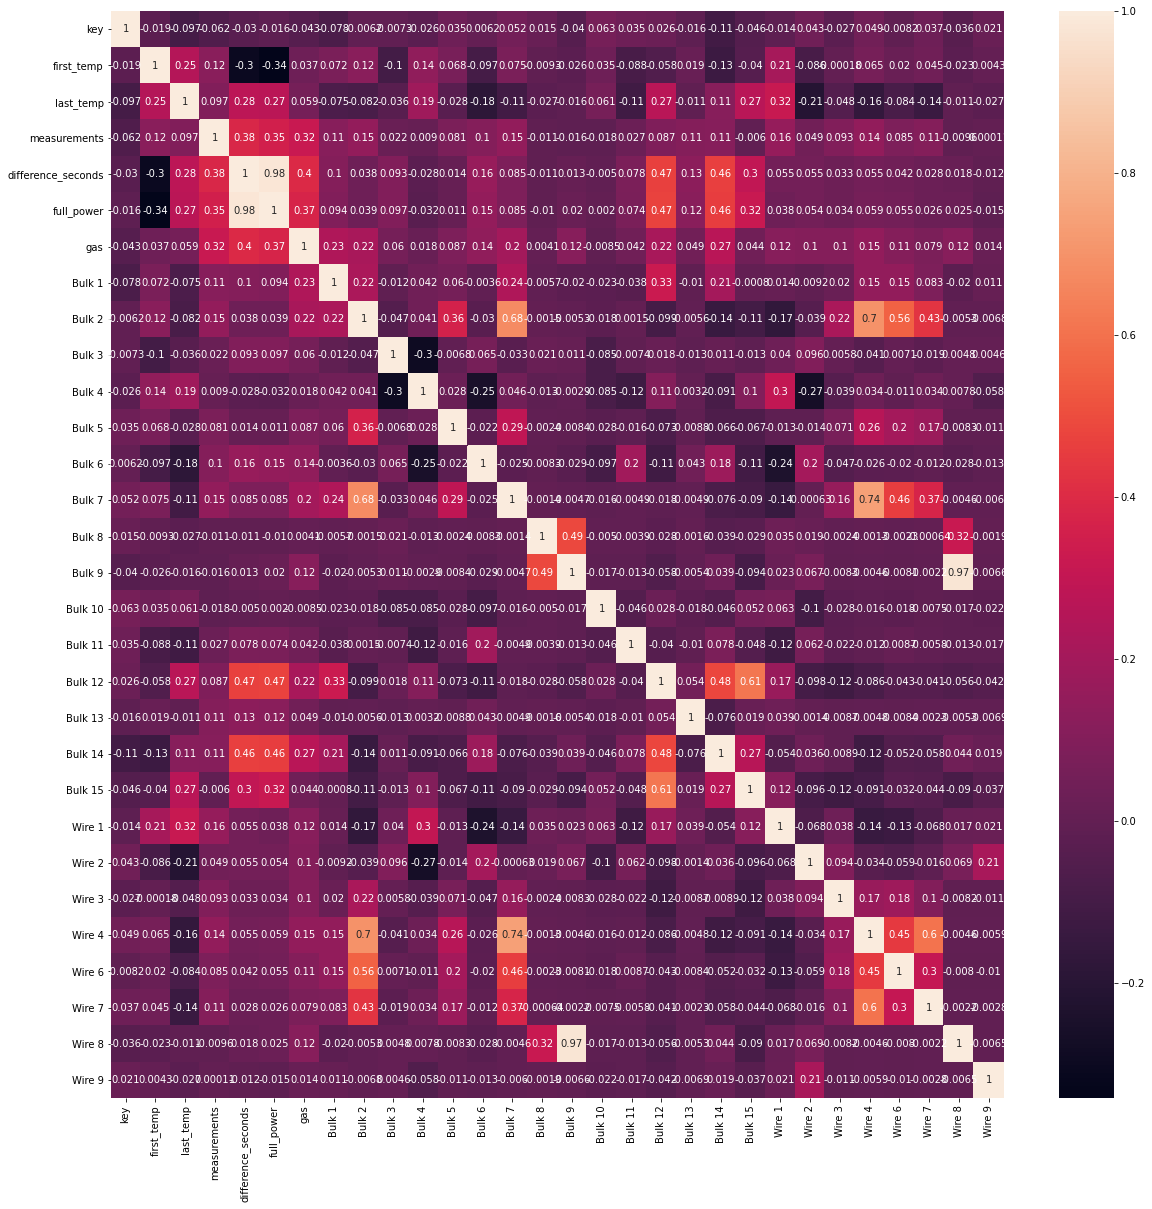

In [42]:
fig = plt.subplots(figsize=(20,20))
sns.heatmap(df_new.corr(), annot = True)
plt.show()

Можно заметить сильно коррелирующие Bulk 9 и Wire 8. Во избежание переобучения удалим Wire 8. Аналогично поступим с парой full_power и difference_seconds, удалив difference_seconds:

In [43]:
df_new = df_new.drop(['Wire 8', 'difference_seconds'], axis=1)

Воспользуемся KNN для поиска аномалий:

In [44]:
model = KNN()

df_new_outlier = df_new.copy()

model.fit(df_new_outlier)
df_new_outlier['is_outlier'] =  model.predict(df_new_outlier) == 1 
outliers_knn = df_new_outlier['is_outlier'].sum()
print("Количество аномалий (KNN): ", outliers_knn)

outlier_indexes = list(df_new_outlier[df_new_outlier['is_outlier'] == 1].index)
good_indexes = list(set(df_new_outlier.index) - set(outlier_indexes))

df_final = df_new_outlier.drop(outlier_indexes)
df_final = df_final.drop('is_outlier', axis=1)
df_final.shape

Количество аномалий (KNN):  197


(2132, 28)

**ВЫВОД**

Из данных удалены сильно коррелирующие столбцы и аномалии. Таким образом, данные готовы к машинному обучению.

## Обучение моделей

Целевым признаком является конечная температура. Разобьем данные на тренировочную и тестовую выборки в соотношении 75/25:

In [45]:
features = df_final.drop('last_temp', axis=1)
target = df_final['last_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=12345)

Поскольку в данных присутствуют количественные признаки с разными разбросами значения, необходимо произвести масштабирование признаков:

In [46]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Перед нами стоит задача регрессии, потому при обучении будем использовать следующие модели:
- LinearRegression
- CatBoostRegressor
- LGBMRegressor

Напишем функцию, которая выдаст MAE на тренировочк=ной выборке:

In [47]:
train_result_list=[]
def give_me_mae(model):
    train_predictions = model.predict(features_train)
    train_result_list.append({ 'train_mae_score': mean_absolute_error(target_train, train_predictions)})

In [48]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

LinearRegression()

In [49]:
model_cat=CatBoostRegressor(iterations=10,learning_rate=1,depth=5, random_seed=12345)
model_cat.fit(features_train, target_train)

0:	learn: 9.1423053	total: 49.5ms	remaining: 446ms
1:	learn: 8.3070511	total: 51.6ms	remaining: 206ms
2:	learn: 7.9674759	total: 53.4ms	remaining: 125ms
3:	learn: 7.7779528	total: 55.2ms	remaining: 82.8ms
4:	learn: 7.5609359	total: 57.1ms	remaining: 57.1ms
5:	learn: 7.4706424	total: 58.9ms	remaining: 39.3ms
6:	learn: 7.3578803	total: 60.7ms	remaining: 26ms
7:	learn: 7.2627020	total: 62.7ms	remaining: 15.7ms
8:	learn: 7.2103403	total: 64.4ms	remaining: 7.16ms
9:	learn: 7.0749414	total: 66.2ms	remaining: 0us


In [50]:
model_LGBM = LGBMRegressor(n_estimators=100, max_depth=5, boosting_type = 'gbdt', random_state=12345)
model_LGBM.fit(features_train, target_train)

LGBMRegressor(max_depth=5, random_state=12345)

In [51]:
give_me_mae(model_linear)
give_me_mae(model_cat)
give_me_mae(model_LGBM)

In [52]:
train_result = pd.DataFrame(train_result_list, columns=['train_mae_score'], index=['LinearRegression','CatBoost','LGBM'])
train_result

,train_mae_score
LinearRegression,5.871421
CatBoost,5.485596
LGBM,3.857818


Все модели показали выдали требуемые значения MAE на тренировочной выборке. Теперь проверим на тестовой!

In [53]:
test_result_list=[]
def give_me_test_mae (model):
    test_predictions=model.predict(features_test)
    test_result_list.append({ 'test_mae_score': mean_absolute_error(target_test, test_predictions)})

In [54]:
give_me_test_mae(model_linear)
give_me_test_mae(model_cat)
give_me_test_mae(model_LGBM)

In [55]:
test_result = pd.DataFrame(test_result_list, columns=['test_mae_score'], index=['LinearRegression','CatBoost','LGBM'])
train_and_test = train_result.join(test_result)
train_and_test

,train_mae_score,test_mae_score
LinearRegression,5.871421,6.432906
CatBoost,5.485596,5.673661
LGBM,3.857818,5.327166


**ВЫВОД**

Все исследуемые модели выдали MAE, не превышающее 6,5, что соответствует требованиям задания. Наилучшей оказалась модель LGBM, продемонстрировавшая на тестовой выборке MAE=5,33.

## Отчет о проделанной работе

В самом начале работы был составлен план действий.

На первом этапе был произведен обзор данных, в результате которого выявлены пропуски, явные выбросы, несоответствие типов и разное количество уникальных номеров партии (может быть связано с утерей данных)

Далее, согласно плану, была произведена предобработка данных, в результате которой нужные для решения задачи данные были объединены в одну таблицу, где для каждой партии были оставлены только начальная и конечная температуры во избежание утечки целевого признака. Пропуски заменены, неинформативные строки удалены.

На этапе исследовательского анализа данных составлена матрица корреляции. Были проверены попарно коррелирующие признаки. Также с помощью KNN из данных были удалены аномалии. Составлен итоговый датасет.

На этапе обучения моделей выделен целевой признак - конечная температура. Датасет разделен на обучающую и тестовую выборки в соотношении 75/25. Признаки отмасштаброваны. Подобраны модели для решения задачи регресии: LinearREgression, CatBoost и LGBM. По итогу, все изученные модели позволили получить требуемое значение метрики MAE как на обучающей, так и на тестовой выборке. Лучше моделью оказалась LGBM, которой на тестовой выборке удалось достичь MAE=5,33.